# Supervised Topic modelling :


This is a multi-class classification problem. The data input is the forum post title and content, the labels are the tag associated with it.
We downloaded tags that correspond to each stackOverflow post, so we can train supervised model to handle this.
The number of classes outputs is the number of different label present in the label corpus.

**Preprocessing** :
- We need to assure that the training dataset is balanced and our test set is representative.

An interesting point here :"representative" dataset and "balanced" is usually contradictory as the real word data is often not balanced. For instance "python" tags is more likely to appear than "spacy" so the model might be biased towards python label. 

This will also affect the cost function. If the data is not balanced (one class in predominant for instance) the model will tend to be biased towards this class. This false classification must be take care of during training.

-  to avoid the curse of dimensionality issue (as our word corpus is very large) we will use prior LSA and word-embedding representation technique.


**Model Benchmark**

- Logistic regression : one-vs-rest
- SVM 
- Random forest 
- NN : in second supervised notebook

Three different neural network data preparation approach :
- Word2VEc
- BERT
- USE

 This 6 different global model will be compared and selected with ??? (acuracy ? ).
 The best supervised approach will be compared with supervised learning algorithm  through accuracy prediction ???

furthermore we will implement a dummy classifier to be sure that the model performs better that a simple approach (based on apperence frequency in the training set ) )

**Evaluation**
We will use cross-validation for model evaluation. So we need to split our dataset into train/validation/test.






some articles specify that we can filter out features that scores low in information theory (information gain, Chi squared). So keep documennts word representation that is the most discriminative ones.

In [1]:
try :
    from google.colab import drive
    drive.mount('/content/drive')
    output_dir = "/content/drive/MyDrive/OpenClassroom/"
    # !pip install bertopic
    IN_COLAB = True
except :
    IN_COLAB = False
    output_dir = "./output/"

In [53]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# word count
import gensim
import gensim.corpora as corpora
from gensim.models import Word2Vec

from scipy.sparse import csr_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.decomposition import TruncatedSVD

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import jaccard_score, average_precision_score


In [82]:
sto_corpus = np.load(f"{output_dir}corpus.npy",allow_pickle=True)
sto_corpus_tags = np.load(f"{output_dir}corpus_tags.npy",allow_pickle=True)

sto_titles = np.load(f"{output_dir}bag_of_words_titles.npy",allow_pickle=True)
sto_body = np.load(f"{output_dir}bag_of_words_body.npy",allow_pickle=True)

# Balanced or representative dataset  ?

In [83]:
sto_corpus = sto_corpus[:2000]
sto_titles = sto_titles[:2000]
sto_body = sto_body[:2000]
sto_corpus_tags = sto_corpus_tags[:2000]

In [25]:
tags = []
for text_tags in sto_corpus_tags:
  tags.extend(iter(text_tags))

In [27]:
tags_series = pd.Series(tags)
print( f"Number of tags : {tags_series.value_counts().shape}" )

Number of tags : (2121,)


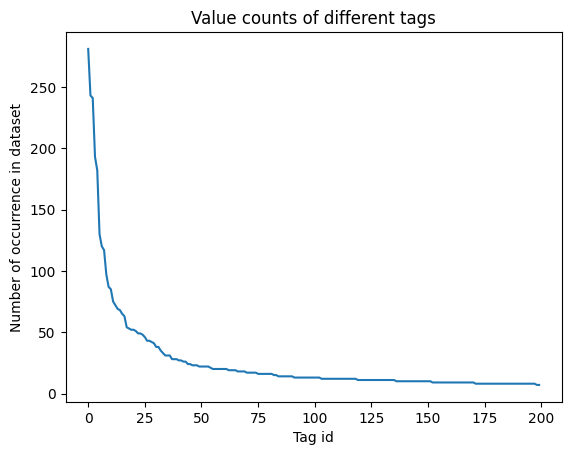

In [30]:
plt.plot(tags_series.value_counts().head(200).values)
plt.xlabel("Tag id")
plt.ylabel("Number of occurrence in dataset")
plt.title("Value counts of different tags")
plt.show()

## Number of classes
I want to focus on main tags, therefore thanks to the graphic above I selected **30 tags**.


In [31]:
labels = tags_series.value_counts().head(30)
labels

c#                281
c++               243
java              241
javascript        193
python            182
ios               130
.net              120
c                 117
android            97
php                87
html               85
performance        75
jquery             72
sql                69
algorithm          68
objective-c        65
asp.net            63
iphone             54
sql-server         53
css                52
c++11              52
linux              51
spring             49
mysql              49
windows            48
swift              46
arrays             43
multithreading     43
node.js            42
json               41
Name: count, dtype: int64

In [32]:
# each label is associated to an id between 0 and 29 by a dictionary
label_list = np.array(labels.index)
d = dict(zip(label_list, range(0,len(label_list))))

# The Multi-Label classification :

Multi-label classification is different form Multi-label classification.  In multi-class classification, each instance belong to a specific label, in multi-class classification, a instance may belong to 0 or multiple class.

Here, each instance of our dataset has multiple labels. The prediction is therefore mutually non-exclusive.
We need a model that can predict zero or more class.

My first idea was to handle multi-label classification as multi-class classification. I generated a dataset repeating the instance for each tag labelled. This was not a good idea. Classification methods using one-vs-one or one-vs-rest ( based on Logistic regression or SVM classifiers) where searching difference between data that could have actually the same label.

Therefore, I let the data be multi-label data.




issue mutilicall can be multiple labels ???
real data
text -> mutiple tags
if text - > 2 tags in labels :
text - > tag1
tes=xt - > tag2 in train /tests datasets.


In [35]:
# multi-label classification
def retrieve_tag_in_selected_list(tags_list, selection_list):
  tags_list_selection = []
  for tags in tags_list:
    tmp = [ d[tag] for tag in tags if tag in selection_list  ]
    tags_list_selection.append( tmp )
  return tags_list_selection

Y_n = retrieve_tag_in_selected_list(sto_corpus_tags, labels)


In [36]:
print(len(sto_corpus_tags))
print(len(Y_n))

2000
2000


In [37]:
Y_n[:10]

[[4, 14], [], [7, 26], [3, 9], [2], [3, 9], [5], [0, 6, 1], [24], [1, 7]]

## data and label  preparation  :
Use of pretrained word embeddings.

use either for data preparation of as first layer

## X_train, X_test, Y_train, Y_test slip

This is done before tfidf to avoid data leakage

In [84]:
(
    X_corpus_train,
    X_corpus_test,
    X_title_train,
    X_title_test,
    X_body_train,
    X_body_test,
    y_train,
    y_test,
) = train_test_split(sto_corpus, sto_titles, sto_body, Y_n, test_size=0.2, random_state=1)

In [85]:
np.save(f"{output_dir}X_corpus_train.npy",X_corpus_train,   allow_pickle=True)
np.save(f"{output_dir}X_corpus_test.npy", X_corpus_test,   allow_pickle=True)

np.save(f"{output_dir}X_title_train.npy", X_title_train, allow_pickle=True)
np.save(f"{output_dir}X_title_test.npy",  X_title_test, allow_pickle=True)

np.save(f"{output_dir}X_body_train.npy",X_body_train,   allow_pickle=True)
np.save(f"{output_dir}X_body_test.npy", X_body_test,   allow_pickle=True)

np.save(f"{output_dir}y_train.npy",       y_train, allow_pickle=True)
np.save(f"{output_dir}y_test.npy",        y_test,   allow_pickle=True)
np.save(f"{output_dir}label_list.npy",    label_list,   allow_pickle=True)


c:\dev\topic_modelling\lib\site-packages\numpy\lib\npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [86]:
print( len(X_title_train) )
print( len(X_corpus_train) )
print( len(X_title_test) )
print( len(y_test)       )

1600
1600
400
400


In [87]:
y_test[:5]

[[4, 14], [3, 5, 15], [1], [1], [1]]

# TFIDF

In [49]:
def getTDF(corpus, dic ):
    """ retrun Term Document Frequency"""
    return  [ dic.doc2bow(text) for text in corpus]

In [50]:
id2word = corpora.Dictionary(X_corpus_train)
corpus = getTDF(X_corpus_train, id2word)
tfidf = gensim.models.TfidfModel(corpus)

tfidf_corpus = tfidf[getTDF(X_corpus_train, id2word)]
tfidf_title = tfidf[getTDF(X_title_train, id2word)]

In [51]:
X_train = [
    np.append(X_title_train[i], X_corpus_train[i]) for i in range(len(X_title_train))
]
tfidf_c_train = tfidf[getTDF(X_train, id2word)]

X_test = [
    np.append(X_title_test[i], X_corpus_test[i]) for i in range(len(X_title_test))
]
tfidf_c_t_test = tfidf[getTDF(X_test, id2word)]

In [52]:
print(len(tfidf_c_train) )
print(len(tfidf_c_t_test))

1600
400


# LSA

In [54]:
def tfidf_to_xsparse(tfidf_in, nb_lines, nb_cols):
    """Convert the TF-IDF corpus into a sparse matrix"""
    rows, cols, data = [], [], []
    for i, doc in enumerate(tfidf_in):
        for j, value in doc:
            rows.append(i)
            cols.append(j)
            data.append(value)
    return csr_matrix((data, (rows, cols)), shape=(nb_lines, nb_cols))

In [55]:
# TRAIN
X_sparse = tfidf_to_xsparse(tfidf_c_train, len(tfidf_c_train), len(id2word))

svd = TruncatedSVD(
    n_components=1100, n_iter=7, random_state=33
)  

# train LSA on train set
X_svd = svd.fit_transform(X_sparse)

# apply PCA on test set
X_sparse_test = tfidf_to_xsparse(tfidf_c_t_test, len(tfidf_c_t_test), len(id2word))
X_svd_test = svd.transform(X_sparse_test)

In [56]:
print(X_sparse.shape)
print(X_svd.shape)
print(X_sparse_test.shape)
print(X_svd_test.shape)

(1600, 38876)
(1600, 1100)
(400, 38876)
(400, 1100)


In [60]:
X_res, y_res = X_svd, y_train

# Logistic regression : One VS Rest

In [69]:
mlb = MultiLabelBinarizer()
y_train_b = mlb.fit_transform(y_train)
y_test_b = mlb.transform(y_test)

model = MultiOutputClassifier(LogisticRegression(multi_class='multinomial'))
model.fit(X_svd, y_train_b)

MultiOutputClassifier(estimator=LogisticRegression(multi_class='multinomial'))

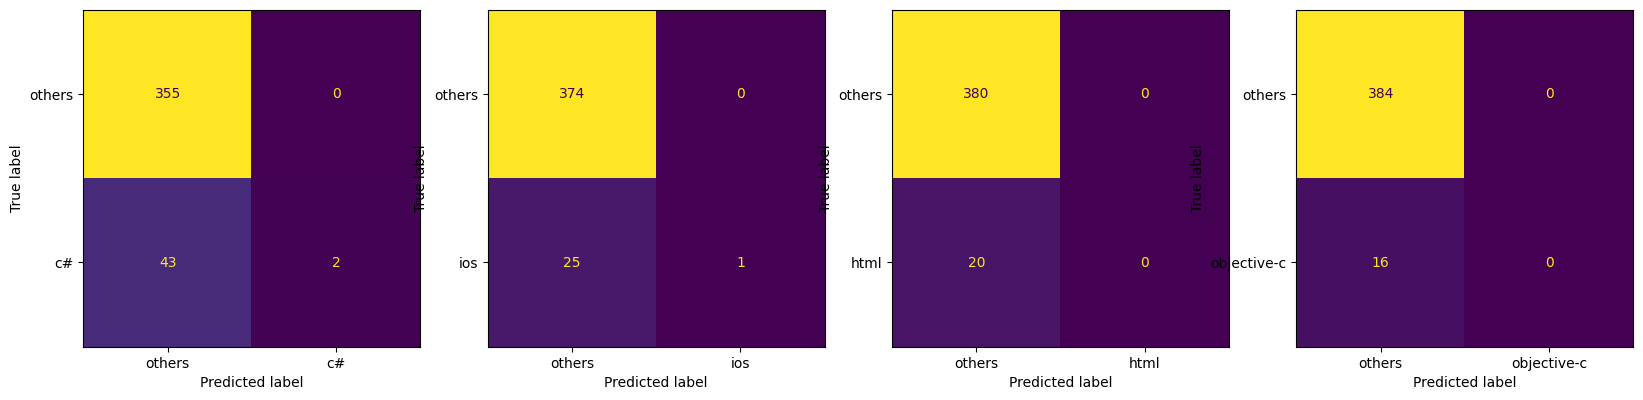

In [70]:
def plot_counf_matrix(y_test, y_pred, NB_LABEL = 4):

  fig, axs = plt.subplots(1,NB_LABEL, figsize=(NB_LABEL*5,5))
  for i in range(NB_LABEL) :
    rdm_label = i *5
    cm = multilabel_confusion_matrix(y_test, y_pred )[rdm_label]


    display_labels = ["others", label_list[rdm_label] ]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=display_labels)
    disp.plot(ax=axs[i],colorbar=False)

  plt.show()

yhat = model.predict(X_svd_test)
plot_counf_matrix(y_test_b, yhat)

[ True Negative , false positive] ,
[False negative, true positivve ]

## Evaluation :    
average precision : summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold
jaccard similarity coefficient  : size of intersection divided by the size of the union

micro : to calculate the metric globally as it is multi-label case

In [71]:
precision_logistic = average_precision_score(y_test_b, yhat, average='micro')
jaccard_score_logistic = jaccard_score(y_test_b, yhat, average='micro')

## SVM : Support Vector Classification (SVC) one vs one

In [72]:
regressor = MultiOutputClassifier(svm.SVC(decision_function_shape='ovo',kernel='rbf'))
regressor.fit(X_svd, y_train_b)

MultiOutputClassifier(estimator=SVC(decision_function_shape='ovo'))

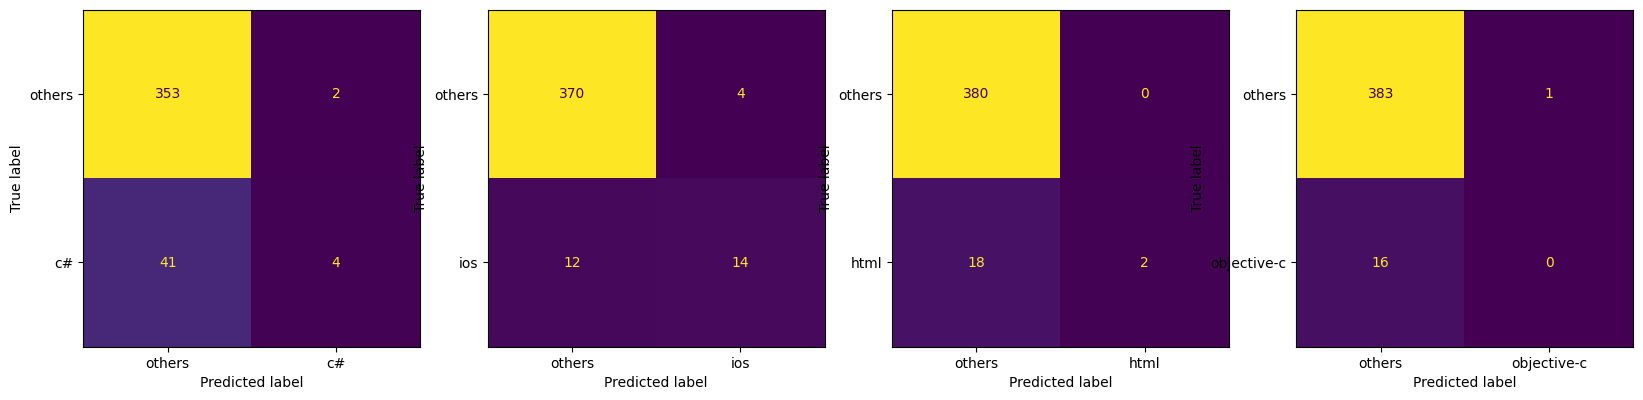

In [73]:
y_pred = regressor.predict(X_svd_test)
plot_counf_matrix(y_test_b, y_pred)

In [74]:

precision_svm = average_precision_score(y_test_b, y_pred, average='micro')
jaccard_score_svm = jaccard_score(y_test_b, y_pred, average='micro')

# Random forest

## Consecutive grid-search for hyperparameters tunning :

In [88]:
n_estimators = [50, 100]  # number of trees in the random forest
max_depth = [2]  # maximum number of levels allowed in each decision tree
min_samples_split = [2]  # minimum sample number to split a node
min_samples_leaf = [1]  # minimum sample number that can be stored in a leaf node

first_grid = {
    "n_estimators": n_estimators,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
}

rf = RandomForestRegressor()
grid_seach_rf = GridSearchCV(rf, first_grid)  #  default 5-fold cross validation,

grid_seach_rf.fit(X_svd, y_train_b)

print("Random grid: ", grid_seach_rf, "\n")
print("Best Parameters: ", grid_seach_rf.best_params_, " \n")

KeyboardInterrupt: 

In [77]:
print("Random grid: ", grid_seach_rf, "\n")
print("Best Parameters: ", grid_seach_rf.best_params_, " \n")

Random grid:  GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 5, 10, 20],
                         'min_samples_leaf': [1, 4],
                         'min_samples_split': [2, 10],
                         'n_estimators': [10, 50, 100]}) 



AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [ ]:
n_estimators = [5, 20, 50, 100]  # number of trees in the random forest
max_features = ["auto", "sqrt"]  # number of features in consideration at every split
max_depth = [
    int(x) for x in np.linspace(10, 120, num=12)
]  # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10]  # minimum sample number to split a node
min_samples_leaf = [1, 3, 4]  # minimum sample number that can be stored in a leaf node
bootstrap = [True, False]  # method used to sample data points

random_grid = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
}
## Importing Random Forest Classifier from the sklearn.ensemble

rf = RandomForestRegressor()
grid_seach_rf = GridSearchCV(rf, first_grid)  #  default 5-fold cross validation,

grid_seach_rf.fit(X_svd, y_train_b)

print("Random grid: ", grid_seach_rf, "\n")
print("Best Parameters: ", grid_seach_rf.best_params_, " \n")

In [ ]:
fsvsfvb

In [89]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_svd, y_train_b)

RandomForestRegressor()

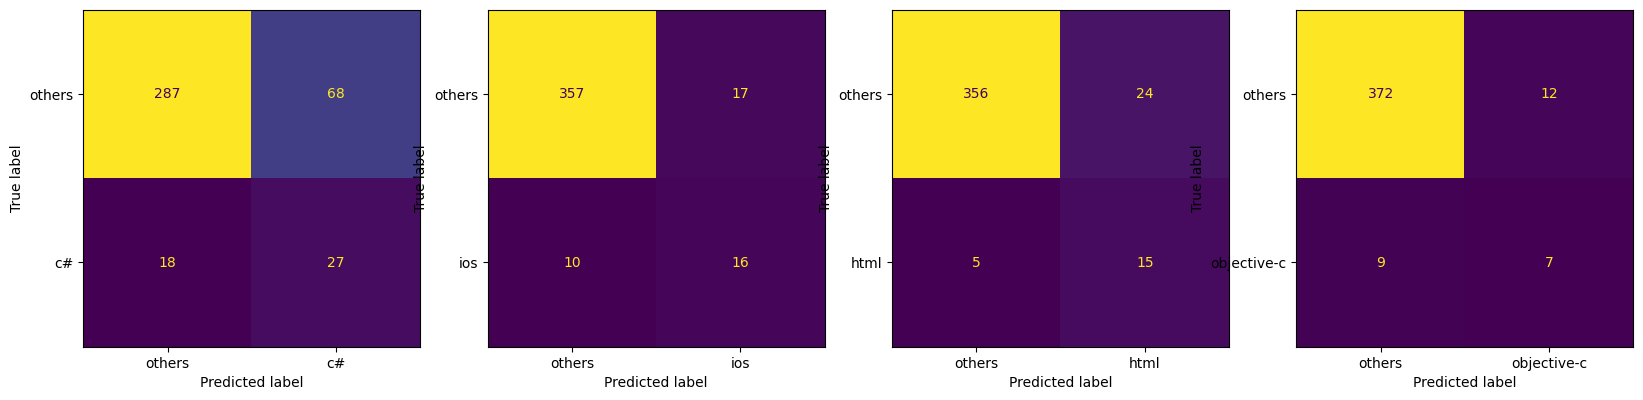

In [95]:
y_pred_rf = rf.predict(X_svd_test)
y_pred_rf = (y_pred_rf > 0.1).astype(np.float32)
plot_counf_matrix(y_test_b, y_pred_rf)

In [101]:
precision_rf      = average_precision_score(y_test_b, y_pred_rf, average='micro')
jaccard_score_rf = jaccard_score(y_test_b, y_pred_rf, average='micro')

## Evaluation 

In [102]:
avg_precision_scores = [precision_logistic, precision_svm, precision_rf]
jaccard_scores = [jaccard_score_logistic, jaccard_score_svm, jaccard_score_rf]
result = pd.DataFrame(
    {
        'average_precision_scores' : avg_precision_scores,
        'jaccard_scores' : jaccard_scores
    }, index = ['logistic','SVM','RandomForest']
)
result.to_csv(f"{output_dir}result_supervised1.csv")

In [103]:
result

,average_precision_scores,jaccard_scores
logistic,0.075111,0.032479
SVM,0.192487,0.178512
RandomForest,0.223417,0.284742
